In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import lines
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import ElasticNet, LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import KernelPCA, PCA
from sklearn import utils
import seaborn as sns
import warnings
from scipy import stats
import copy 

sns.set()
%matplotlib inline

In [3]:
data = np.load('classification.npz')

# X_train
# X_valid
# y_train
# y_valid


In [4]:
print('X_train shape: {}; \n y_train shape: {}; \
       \n X_valid shape: {}; \n y_valid shape: {}'.format(data['X_train'].shape,
                                                          data['y_train'].shape,
                                                          data['X_valid'].shape,
                                                          data['y_valid'].shape))

#Binary Classification

X_train shape: (323, 800); 
 y_train shape: (323,);        
 X_valid shape: (175, 800); 
 y_valid shape: (175,)


In [5]:
feature_names = np.core.defchararray.add('Var ', np.arange(1, 801).astype(str))
feature_df = pd.DataFrame(data['X_train'], columns=feature_names)
selected_features = feature_df[[feature_names[np.random.randint(0,800)] for _ in range(5)]]

In [12]:
selected_features

,Var 557,Var 134,Var 597,Var 361,Var 491
0,0.081749,2.526678,3.037170,4.161865,7.194440
1,0.187508,3.815388,-1.309411,4.310652,8.019544
2,0.780286,3.305561,0.239186,6.593176,4.304512
3,0.016995,7.093586,0.647178,2.081278,5.910615
4,0.085188,0.461986,-0.139644,4.665960,8.213933
...,...,...,...,...,...
318,0.231012,4.701871,0.182737,12.022031,2.402431
319,0.191498,3.532032,-2.108520,3.556999,2.553324
320,0.423752,1.877387,-2.082100,5.465728,3.238950
321,0.164425,5.129615,0.366279,8.961600,3.945227


TypeError: regplot() missing 1 required positional argument: 'y'

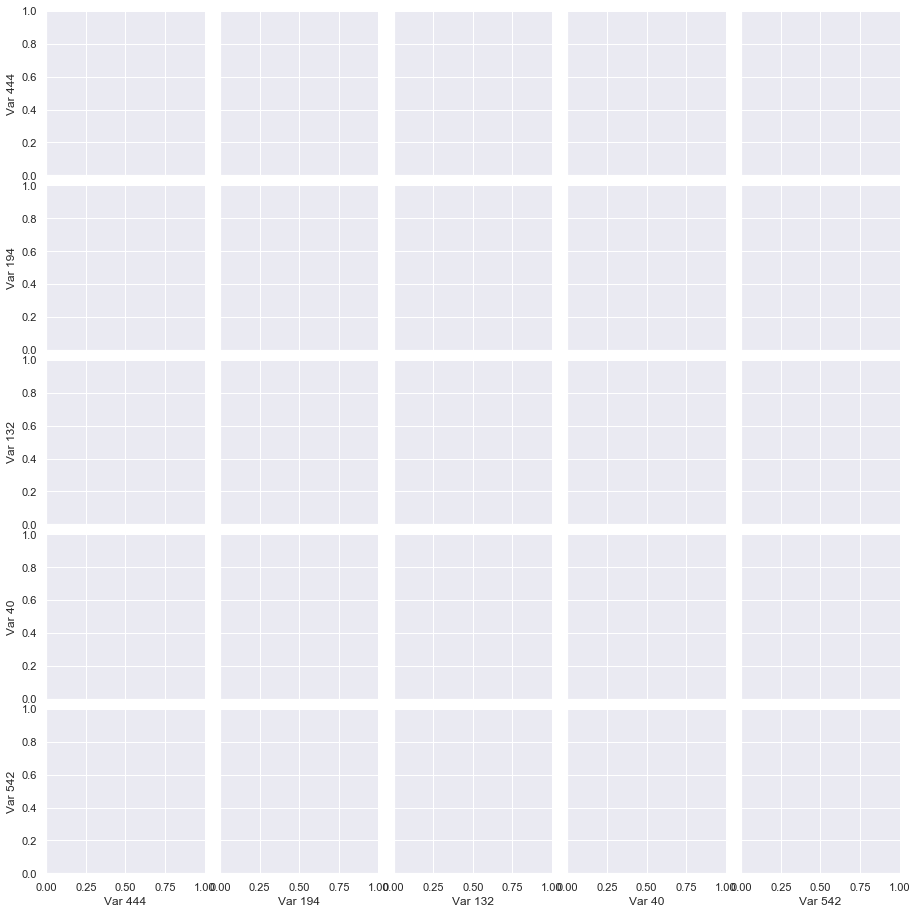

In [6]:
g = sns.PairGrid(selected_features)
g.map_diag(sns.regplot)
g.map_offdiag(sns.regplot, n_levels=6);
g.savefig('dataviz2')

In [ ]:
selected_features.insert(5, 'targets', data['y_train'])

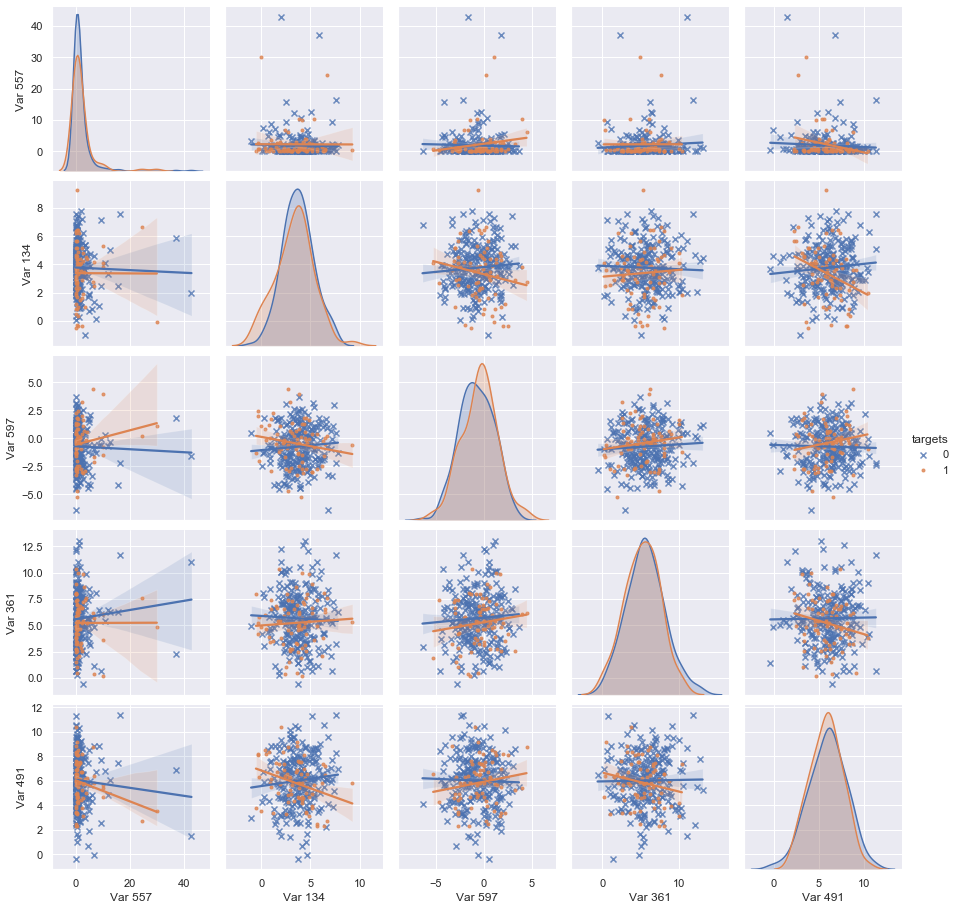

In [253]:
g = sns.pairplot(selected_features, kind="reg", hue='targets', markers=['x', '.'])
g.savefig('lin reg ex1')

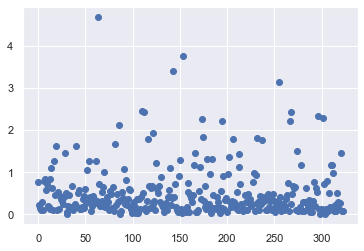

In [67]:
plt.scatter(np.arange(323), data['X_train'][:, 7])

In [7]:
# In order to use GridSearchCV the validation and train data should be concatenated
X_concat = np.concatenate((data['X_train'], data['X_valid']))
y_concat = np.concatenate((data['y_train'], data['y_valid']))

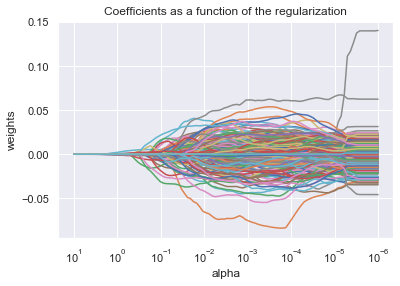

In [8]:
warnings.filterwarnings('ignore')
n_alphas = 100
alphas = np.logspace(-6, 1, n_alphas)
coefs = []
for a in alphas:
    enet = ElasticNet(alpha=a, max_iter=10000)
    enet.fit(data['X_train'], data['y_train'])
    coefs.append(enet.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Coefficients as a function of the regularization')
plt.axis('tight')
plt.savefig('Alpha Regularization', dpi=200)
plt.show()


In [9]:
# Define custom train_test split
test_fold = np.concatenate((np.ones([323,])*-1, np.zeros([175,])))
ps = PredefinedSplit(test_fold)

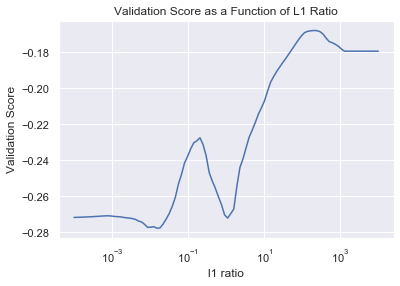

In [10]:
l1_ratio = np.logspace(-4, 4, 100)
enet_test_l1 = GridSearchCV(ElasticNet(max_iter=10000, alpha=0.1),
                    param_grid={'l1_ratio': l1_ratio}, 
                                 scoring='neg_mean_squared_error', cv=ps)
enet_test_l1.fit(X_concat, y_concat)

ax = plt.gca()
ax.plot(l1_ratio, enet_test_l1.cv_results_['mean_test_score'])
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())
plt.xlabel('l1 ratio')
plt.ylabel('Validation Score')
plt.title('Validation Score as a Function of L1 Ratio')
plt.axis('tight')
plt.savefig('l1_ratio Regularization')
plt.show()


In [124]:
## Hyperparameter search elastic net

enet = GridSearchCV(ElasticNet(max_iter=5000),
                    param_grid={
                       'alpha': np.logspace(-2, 0, 20),
                       'l1_ratio': np.logspace(-1, 0, 30)}, 
                    scoring='r2', cv=ps)
enet.fit(X_concat, y_concat)
print(enet.best_params_)
print(enet.best_score_)

{'alpha': 1.0, 'l1_ratio': 1.0}
-0.15669210539601264


In [ ]:
## Hyperparameter search logisticRegressionCV

log_cv = LogisticRegressionCV(cv=ps, penalty='elasticnet', solver='saga',
                              l1_ratios=np.logspace(-4, 0, 50), scoring='accuracy').fit(X_concat, y_concat)

In [1]:
ntimes_nonzero = np.zeros(800).astype(int)
sample_enet=[]
for i in range(200):
    resapmpled_X , resampled_y = utils.resample(data['X_train'], data['y_train'])
    sample_enet.append(LogisticRegression(penalty='elasticnet', solver='saga', 
                                  C=log_cv.C_[0] , l1_ratio=log_cv.l1_ratio_[0]).fit(resapmpled_X, resampled_y))
    nonzero_ind = np.where(sample_enet[i].coef_[0] != 0)[0]
    ntimes_nonzero[nonzero_ind] += 1


NameError: name 'np' is not defined

In [298]:
chosen_predictors = np.where(ntimes_nonzero == 200)[0]

array([ 22,  33,  63,  75,  96, 104, 171, 183, 345, 398, 399, 462, 492,
       523, 533, 571, 575, 594, 671, 697, 724, 778], dtype=int64)

No handles with labels found to put in legend.


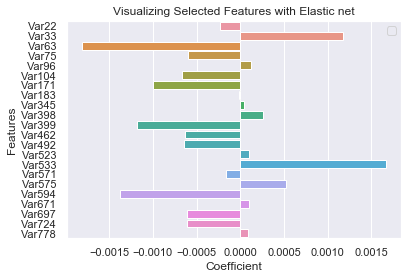

In [315]:
rank_chosen = np.zeros(len(chosen_predictors)) 
for i in range(len(chosen_predictors)):
    for j in range(200):
        rank_chosen[i] += sample_enet[j].coef_[0][chosen_predictors[i]]

rank_chosen = rank_chosen/200 # mean
chosen_predictor_names = np.core.defchararray.add('Var', chosen_predictors.astype(str))
feature_imp_enet = pd.Series(rank_chosen,
                        index=important_features_names).sort_values(ascending=True)

sns.barplot(x=rank_chosen, y=chosen_predictor_names)
# Add labels to your graph
plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.title("Visualizing Selected Features with Elastic net")
plt.legend()
plt.savefig('Elastic net Feature Importance')
plt.show()

In [259]:
list_enets = [LogisticRegression(penalty='elasticnet', solver='saga', 
                                  C=reg , l1_ratio=log_cv.l1_ratio_[0]).fit(data['X_train'], data['y_train']) 
             for reg in np.logspace(-7, 1, 100)]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -4.09874734e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -6.67907229e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.09400240e-05,
        0.00000000e+00,  8.42253677e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -7.57189936e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  6.76588553e-05,  0.00000000e+00,
        0.00000000e+00,  

In [271]:
ranks = {str(i): np.where(list_enets[i].coef_[0] != 0)[0] for i in range(len(list_enets))}
print([len(np.where(list_enets[i].coef_ != 0)[0]) for i in range(len(list_enets))])
ranks_unique = copy.deepcopy(ranks)
for i in range(len(ranks) - 1):
    ranks_unique[str(i)] = set(ranks[str(i+1)]) - set(ranks[str(i)])
ranks_unique

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 4, 5, 7, 8, 9, 12, 12, 12, 14, 15, 15, 17, 18, 21, 23, 24, 30, 33, 36, 40, 42, 44, 45, 48, 52, 58, 69, 76, 82, 84, 93, 104, 127, 173, 234, 295, 366, 412, 457, 514, 548, 598, 636, 672, 695, 717, 731, 741, 745, 750, 753, 757, 760, 762, 767, 773, 780, 783, 783, 787, 789, 792, 793, 795, 797, 798, 798, 798, 798, 800, 800]


{'0': set(),
 '1': set(),
 '2': set(),
 '3': set(),
 '4': set(),
 '5': set(),
 '6': set(),
 '7': set(),
 '8': set(),
 '9': set(),
 '10': set(),
 '11': set(),
 '12': set(),
 '13': set(),
 '14': set(),
 '15': set(),
 '16': set(),
 '17': set(),
 '18': set(),
 '19': set(),
 '20': set(),
 '21': set(),
 '22': set(),
 '23': set(),
 '24': {171, 594},
 '25': set(),
 '26': set(),
 '27': {703},
 '28': {31},
 '29': {183},
 '30': {33, 686},
 '31': {399},
 '32': {63},
 '33': {571, 670, 745},
 '34': set(),
 '35': set(),
 '36': {492, 533},
 '37': {462},
 '38': set(),
 '39': {10, 483},
 '40': {319},
 '41': {341, 697, 724},
 '42': {75, 575},
 '43': {50},
 '44': {20, 44, 96, 104, 345, 398},
 '45': {318, 383, 721},
 '46': {22, 127, 174},
 '47': {122, 223, 649, 694},
 '48': {394, 554, 671},
 '49': {60, 546, 668},
 '50': {192},
 '51': {259, 313, 729},
 '52': {31, 45, 148, 368},
 '53': {49, 79, 124, 459, 559, 667},
 '54': {76, 172, 236, 280, 312, 325, 353, 432, 494, 552, 653},
 '55': {56, 85, 199, 300, 523, 

In [240]:
print(log_cv.l1_ratio_, log_cv.C_)
best_logenet = LogisticRegression(penalty='elasticnet', solver='saga', 
                                  C=log_cv.C_[0] , l1_ratio=log_cv.l1_ratio_[0]).fit(data['X_train'], data['y_train'])

predictions_best_logenet = best_logenet.predict(data['X_valid'])
acc_best_logenet = metrics.accuracy_score(data['y_valid'], predictions_best_logenet)
print(acc_best_logenet, predictions_best_logenet)

[0.47148664] [0.00599484]
0.76 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


AttributeError: 'LogisticRegression' object has no attribute 'cv'

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -6.40525123e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.65118191e-04,  0.00000000e+00, -2.62125128e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.42601392e-05,
        0.00000000e+00,  1.03207157e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -5.76577939e-04, -1.30056814e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  8.13151074e-05,  2.51618624e-04,  0.00000000e+00,
       -4.75113937e-06,  

In [235]:
best_enet = enet.best_estimator_
predicted_enet = best_enet.predict(data['X_valid'])
classified_enet = np.heaviside(predicted_enet-0.5, 1)
enet_accuracy = metrics.accuracy_score(data['y_valid'], classified_enet)
print(enet_accuracy)

predicted_enet_series = pd.Series(predicted_enet)
sns.distplot(predicted_enet_series)
plt.title(f"Distribution of Elastic Net's Predictions, mean= {np.mean(predicted_enet): .2f} ; \
std={np.std(predicted_enet): .2f}")

plt.savefig('Dist Enet Predictions', dpi=200)

AttributeError: 'ElasticNet' object has no attribute 'best_estimator_'

In [190]:
three_std = 3*np.std(predicted_enet)
corrected_enet = np.zeros_like(predicted_enet)
for i in range(len(corrected_enet)):
    if predicted_enet[i] > np.mean(predicted_enet) + three_std:
        corrected_enet[i] = np.mean(predicted_enet) + three_std
    elif predicted_enet[i] < np.mean(predicted_enet) - three_std:
        corrected_enet[i] = np.mean(predicted_enet) - three_std
    else:
        corrected_enet[i] = predicted_enet[i]

normalized_data = np.array([(corrected_enet[i] - min(corrected_enet))/(max(corrected_enet) - min(corrected_enet)) 
                   for i in range(len(corrected_enet))])
corrected_range = max(corrected_enet) - min(corrected_enet)
classified_labels = [1 if i > corrected_range/2 else 0 for i in corrected_enet]
enetcorr_accuracy = metrics.accuracy_score(data['y_valid'], np.heaviside(normalized_data-0.8,1))
enetcorr_accuracy

0.7942857142857143

In [220]:
coef_enet = pd.Series(best_logenet.coef_[0])
print("Elastic Net picked " + str(sum(coef_enet != 0)) + " variables and eliminated the other " +  
      str(sum(coef_enet == 0)) + " variables")

Elastic Net picked 93 variables and eliminated the other 707 variables


In [324]:
## Hyperparameter search random forests
rf = GridSearchCV(RandomForestClassifier(n_estimators=200),
                 param_grid={'min_samples_split': np.arange(2, 30)},
                              scoring='accuracy', cv=ps)
rf.fit(X_concat, y_concat)
print(rf.best_params_)
print(rf.best_score_)

{'min_samples_split': 3}
0.7771428571428571


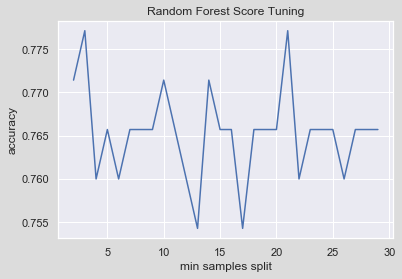

In [325]:
fig = plt.figure(facecolor='gainsboro')
plt.plot(np.arange(2, 30) , rf.cv_results_['mean_test_score'])
plt.xlabel('min samples split')
plt.ylabel('accuracy')
plt.title('Random Forest Score Tuning')
plt.savefig('Random Forest Score Tuning')

In [254]:
rf = GridSearchCV(RandomForestClassifier(n_estimators=200, min_samples_split=16),
                 param_grid={'min_samples_leaf': np.arange(1, 30)},
                              scoring='accuracy', cv=ps)
rf.fit(X_concat, y_concat)
print(rf.best_params_)
print(rf.best_score_)

{'min_samples_leaf': 1}
0.7714285714285715


Text(0.5, 1.0, 'Random Forest Score Tuning')

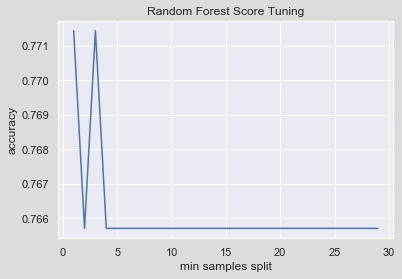

In [256]:
fig = plt.figure(facecolor='gainsboro')
plt.plot(np.arange(1, 30) , rf.cv_results_['mean_test_score'])
plt.xlabel('min samples split')
plt.ylabel('accuracy')
plt.title('Random Forest Score Tuning')

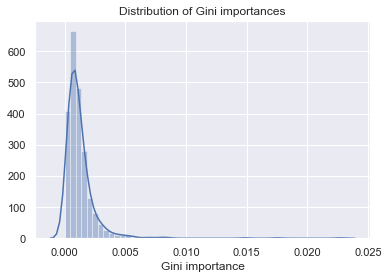

In [322]:
best_rf = rf.best_estimator_
gini_importances = best_rf.feature_importances_
gini_importances = pd.Series(gini_importances, name="Gini importance")
sns.set()
sns.distplot(gini_importances)
plt.title('Distribution of Gini importances')
plt.savefig('Distribution of Gini importances')

In [336]:
sample_forest = []
gini_impor_array = np.zeros(800)
for i in range(20):
    resapmpled_X , resampled_y = utils.resample(data['X_train'], data['y_train'])
    sample_forest.append(RandomForestClassifier(min_samples_split=3, n_estimators=200).fit(resapmpled_X, resampled_y))
    for j in range(800):
        gini_impor_array[j] += sample_forest[i].feature_importances_[j]
        
gini_impor_array = gini_impor_array/20

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

No handles with labels found to put in legend.


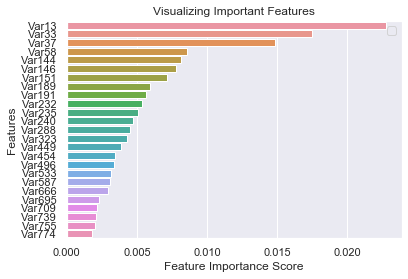

In [340]:
important_features = np.argwhere(gini_impor_array >= 0.003)
important_features_names = np.core.defchararray.add('Var', important_features.astype(str)[:, 0])
feature_imp = pd.Series(best_rf.feature_importances_[important_features[:, 0]],
                        index=important_features_names).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=important_features_names)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.savefig("important features rf")
plt.legend()
plt.show()

In [274]:
important_features = np.argwhere(gini_importances >= 0.004)
important_features_names = np.core.defchararray.add('Var', important_features.astype(str)[:, 0])
feature_imp = pd.Series(best_rf.feature_importances_[important_features[:, 0]],
                        index=important_features_names).sort_values(ascending=False)

No handles with labels found to put in legend.


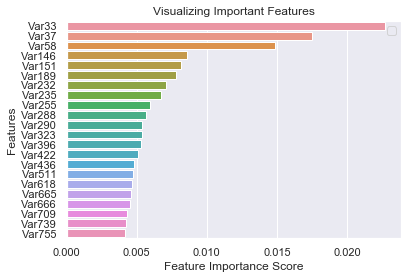

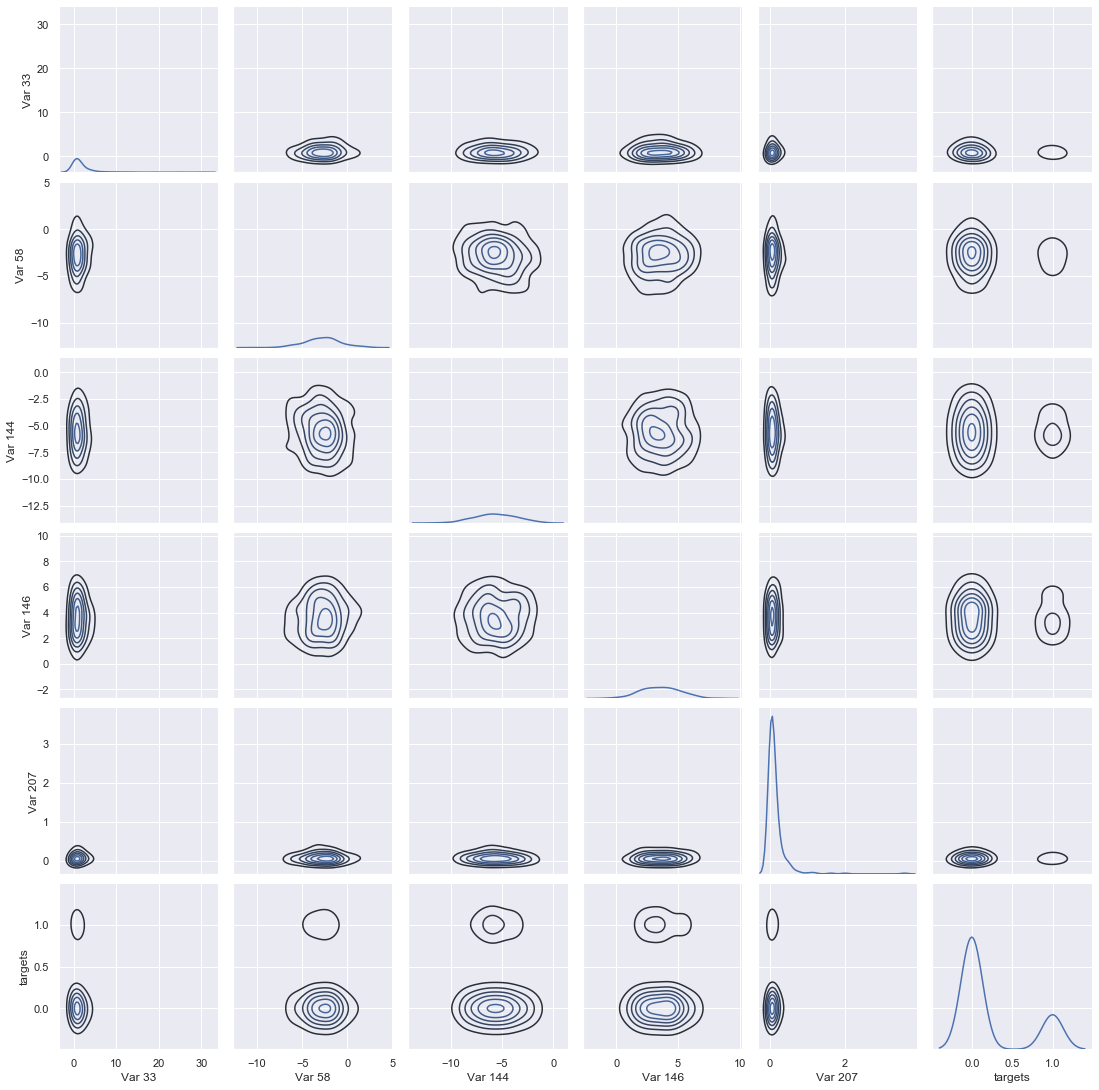

In [55]:
top5_important = ['Var 33', 'Var 58', 'Var 144', 'Var 146', 'Var 207']
top5_importantdf = feature_df[top5_important]
top5_importantdf.insert(5, "targets", data['y_train'], True) 

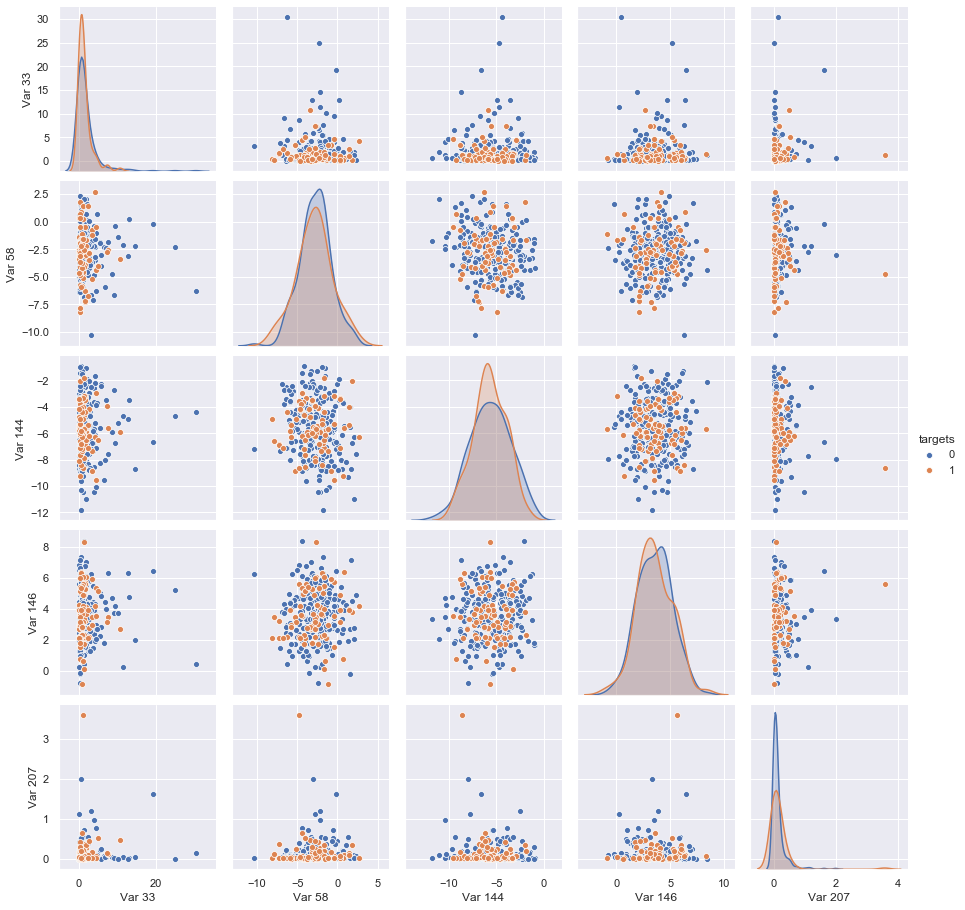

In [61]:
g_top5 = sns.pairplot(top5_importantdf, hue='targets')
g_top5.savefig('top5important')

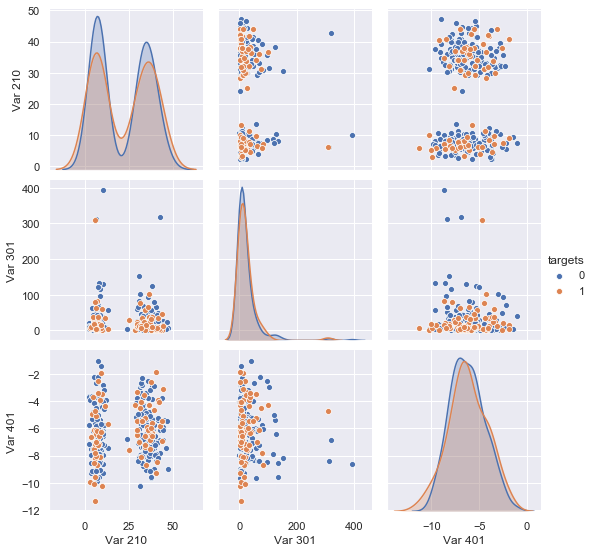

In [186]:
some_features = feature_df[feature_names[[209, 300, 400]]]
some_features.insert(3, 'targets', data['y_train'])
some_pairplot = sns.pairplot(some_features, hue='targets')
plt.savefig('bizzare variable', dpi=200)

In [177]:
feature_names[[1,2,3]]

array(['Var 2', 'Var 3', 'Var 4'], dtype='<U15')

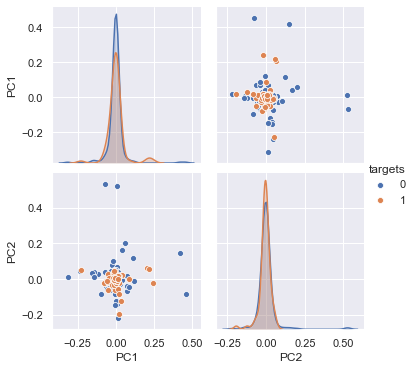

In [145]:
reduced_data = KernelPCA(n_components=2, kernel='rbf').fit(data['X_train'])
reduced_data_points = KernelPCA(n_components=2, kernel='rbf').fit_transform(data['X_train'])
reduced_datadf = pd.DataFrame((reduced_data_points), columns=['PC1', 'PC2'])
reduced_datadf.insert(2, "targets", data['y_train'], True)

g_kpca = sns.pairplot(reduced_datadf, hue='targets')
g_kpca.savefig('kernelPCA')


0.1624342327133208 0.11119034520638088 0.10364689705581842


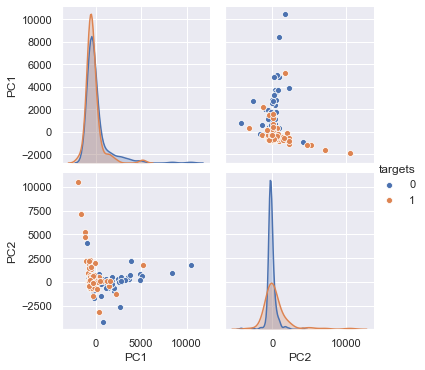

In [169]:
red_opca = PCA(n_components=2).fit_transform(data['X_train'])
opca_datadf = pd.DataFrame((red_opca), columns=['PC1', 'PC2'])
opca_datadf.insert(2, "targets", data['y_train'], True)

g_opca = sns.pairplot(opca_datadf, hue='targets')
g_opca.savefig('ordinary PCA ex1')

pca_fit = PCA(n_components=300).fit(data['X_train'])
print(pca_fit.explained_variance_[0]/sum(pca_fit.explained_variance_),
      pca_fit.explained_variance_[1]/sum(pca_fit.explained_variance_),
      pca_fit.explained_variance_[2]/sum(pca_fit.explained_variance_))

Text(0.5, 0.92, 'Distribution of Data after PCA')

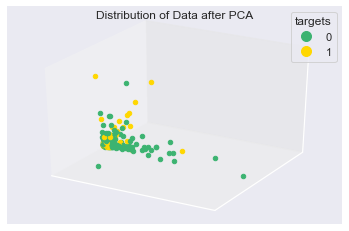

In [164]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(len(data['y_train'])):
    if data['y_train'][i] == 0:
        ax.scatter(red_opca[i, 0], red_opca[i, 1], red_opca[i, 2], c='mediumseagreen')
    else:
        ax.scatter(red_opca[i, 0], red_opca[i, 1], red_opca[i, 2], c='gold')
ax.set_xticks(())
ax.set_yticks(())
ax.set_zticks(())
l_0 = lines.Line2D([], [], color='mediumseagreen', marker='o', linestyle='None',
                        markersize=10, label='0')
l_1 = lines.Line2D([], [], color='gold', marker='o', linestyle='None',
                        markersize=10, label='1')                      
ax.legend(handles=[l_0, l_1], title='targets')
plt.title('Distribution of Data after PCA')


In [342]:
a = [ 22,  33,  63,  75,  96, 104, 171, 183, 345, 398, 399, 462, 492, 523, 533, 571, 575, 594, 671, 697, 724, 778]
b = [171, 594, 703, 31, 183, 33, 399, 63, 571, 670, 745, 492, 533, 462, 10, 483, 341, 697, 724, 75, 575, 20, 44, 96, 104, 345, 398]
np.intersect1d(important_features, b)

array([ 33, 533], dtype=int64)